### **📝 Instructions**
Image classification system
The dataset is composed of dog and cat photos provided as a subset of photos from a much larger collection of 3 million manually annotated photos. This data was obtained through a collaboration between Petfinder.com and Microsoft.

The data set was originally used as a CAPTCHA, i.e., a task that a human is believed to find trivial, but that a machine cannot solve, which is used on websites to distinguish between human users and bots. The task was named "Asirra". When "Asirra" was introduced, it was mentioned "that user studies indicate that humans can solve it 99.6% of the time in less than 30 seconds." Barring a breakthrough in computer vision, we expect that computers will have no more than a 1/54,000 chance of solving it.

At the time the competition was published, the state-of-the-art result was achieved with an SVM and was described in a 2007 paper with the title "Machine Learning Attacks against Asirra's CAPTCHA" (PDF) that achieved 80% classification accuracy. It was this paper that showed that the task was no longer a suitable task for a CAPTCHA shortly after the task was proposed.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.models import load_model

import os
import re

2024-11-01 10:10:02.902136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### **Step 1: Loading the dataset**
The dataset is located in Kaggle and you will need to access it to download it. You can find the competition here (or by copying and pasting the following link in your browser: `https://www.kaggle.com/c/dogs-vs-cats/data)`

Download the dataset folder and unzip the files. You will now have a folder called `train` containing 25,000 image files (.jpg format) of dogs and cats. The pictures are labeled by their file name, with the word `dog` or `cat`.

In [2]:
import shutil
# Use this part to put files into dog and cat folders
'''
# Current training directory
train_dir = "data/raw/train"

# Create subfolders for each class
cat_dir = os.path.join(train_dir, "cat")
dog_dir = os.path.join(train_dir, "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move images to their respective folders
for filename in os.listdir(train_dir):
    if filename.startswith("cat"):
        shutil.move(os.path.join(train_dir, filename), os.path.join(cat_dir, filename))
    elif filename.startswith("dog"):
        shutil.move(os.path.join(train_dir, filename), os.path.join(dog_dir, filename))
        
print("Images organized in folders by class.")
'''

'\n# Current training directory\ntrain_dir = "data/raw/train"\n\n# Create subfolders for each class\ncat_dir = os.path.join(train_dir, "cat")\ndog_dir = os.path.join(train_dir, "dog")\nos.makedirs(cat_dir, exist_ok=True)\nos.makedirs(dog_dir, exist_ok=True)\n\n# Move images to their respective folders\nfor filename in os.listdir(train_dir):\n    if filename.startswith("cat"):\n        shutil.move(os.path.join(train_dir, filename), os.path.join(cat_dir, filename))\n    elif filename.startswith("dog"):\n        shutil.move(os.path.join(train_dir, filename), os.path.join(dog_dir, filename))\n        \nprint("Images organized in folders by class.")\n'

#### **Step 2: Visualize the input information**
The first step when faced with a picture classification problem is to get as much information as possible through the pictures. Therefore, load and print the first nine pictures of dogs in a single figure. Repeat the same for cats. You can see that the pictures are in color and have different shapes and sizes.

This variety of sizes and formats must be sorted out before training the model. Make sure they all have a fixed size of 200x200 pixels.

As you can see, there are a lot of images. Make sure you stick to the following rules:

If you have more than 12 gigabytes of RAM, use the Keras image processing API to load the 25,000 photos into the training dataset and reshape them to 200×200 pixel square photos. The label must also be determined for each photo based on the file names. A tuple of photos and labels should be saved.
If you have no more than 12 gigabytes of RAM, load the images progressively using the Keras `ImageDataGenerator` class and the `flow_from_directory()` function. This will be slower to run but it will run on less capable hardware. This function prefers the data to be split into separate train and test directories, and under each directory to have a subdirectory for each class.

Once you have all the images processed, create an `ImageDataGenerator` object for training and test data. Then pass the folder that has training data to the `trdata` object and, similarly, pass the folder that has test data to the `tsdata` object. In this way, the images will be automatically labeled, and everything will be ready to enter the network.

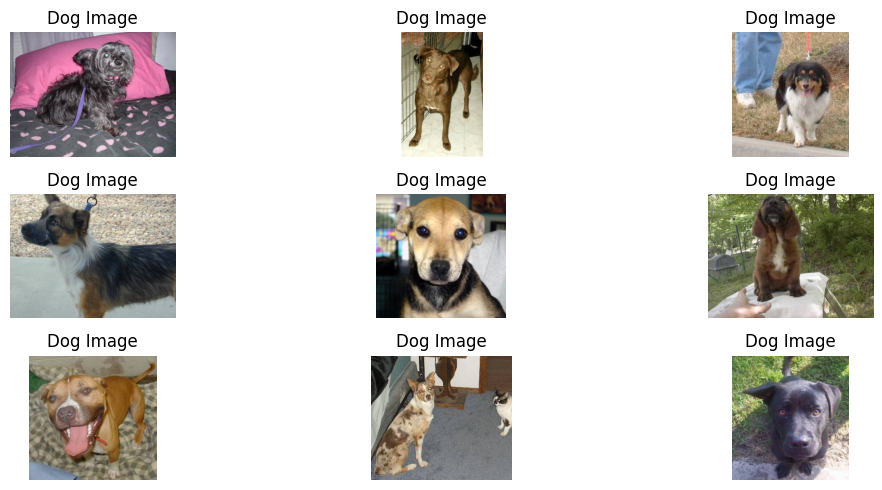

In [3]:
# Path to the directory containing the training images
data_dir = "../data/raw/train/dog"

# Get a list of all dog image file names
dog_image_files = [f for f in os.listdir(data_dir) if f.startswith("dog")]
# Sort list
dog_image_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

# Load the first nine images of dogs
dog_images = []
for i in range(9):
    img_path = os.path.join(data_dir, dog_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    dog_images.append(img_array)

# Create figure
plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dog_images[i])
    plt.title('Dog Image')
    plt.axis('off')

plt.tight_layout()

plt.show()

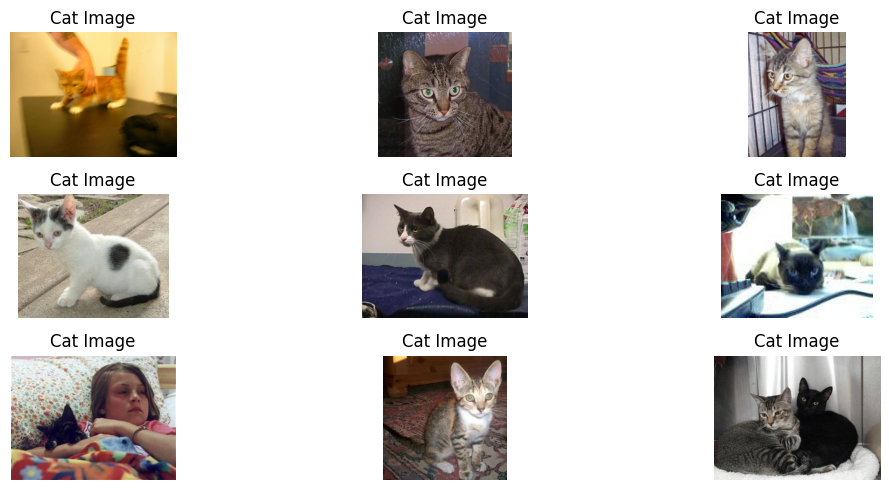

In [4]:
# Path to the directory containing the training images
data_dir = "../data/raw/train/cat"

# Get a list of all dog image file names
cat_image_files = [f for f in os.listdir(data_dir) if f.startswith("cat")]
# Sort list
cat_image_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

# Load the first nine images of dogs
cat_images = []
for i in range(9):
    img_path = os.path.join(data_dir, cat_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    cat_images.append(img_array)

# Create figure
plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cat_images[i])
    plt.title('Cat Image')
    plt.axis('off')

plt.tight_layout()

plt.show()

In [5]:
# Data directories
train_dir = "../data/raw/train"
image_size = (100, 100)

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    image_size=image_size,
    color_mode='grayscale',
    batch_size=32,
    seed=123
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


"\nvalidation_data = datagentest.flow_from_directory(\n    train_dir,\n    target_size = image_size,\n    color_mode='grayscale',\n    batch_size=32,\n    class_mode='sparse',\n    subset='validation',\n)\n"

In [11]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    color_mode='grayscale',
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=123
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


#### **Step 3: Build an ANN**
Any classifier that fits this problem will have to be robust because some images show the cat or dog in a corner, or perhaps 2 cats or dogs in the same picture. If you have been able to research some of the winner implementations of other competitions also related to images, you will see that `VGG16` is a CNN architecture used to win the Kaggle ILSVR (Imagenet) competition in 2014. It is considered one of the best performing vision model architectures to date.

It uses the following test architecture:
```py
model = Sequential()
model.add(Conv2D(input_shape = (224,224,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))
```

The above code applies convolutions to the data (`Conv2D` and `MaxPool2D` layers) and then applies dense layers (`Dense` layers) for processing the numerical values obtained after the convolutions.

Then add the remaining elements to form the model, train it and measure its performance.

In [7]:
# Move data through the neural network
model = Sequential()
model.add(Conv2D(input_shape = (100,100,1), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

# Move data through the dense layers
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

/Users/rodripinedo/DOCS/4Geeks/Repositorios/my_bootcamp/Deep_Learning/machine_learning_project_deep-learning/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model with Adam
from keras.optimizers import Adam

# Compile the model before training
model.compile(
    loss='sparse_categorical_crossentropy',  # Use the loss function name as string
    optimizer=Adam(learning_rate=0.001),  # Using Adam as an optimizer
    metrics=['accuracy']  # Metrics to evaluate performance
)

In [9]:
# Train the model
model.fit(train_data, epochs = 1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2512s 4s/step - accuracy: 0.4959 - loss: 1.4083


#### **Step 4: Optimize the above model**
Import the `ModelCheckpoint` and `EarlyStopping` method from Keras. Create an object of both and pass them as callback functions to `fit_generator`.

Load the best model from the above and use the test set to make predictions.

#### **Step 5: Save the model**
Store the model in the corresponding folder.

In [10]:
# Create the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    "../models/vgg16_best_model.keras",  # Directory where the file is saved and name of the file
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
)

# Create the EarlyStopping callback to stop training if there is no improvement
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,  # Stop after 3 epochs without improvement
    verbose=1,
    mode="auto"
)

# Train the model with callbacks
hist = model.fit(
    train_data,
    steps_per_epoch=100,
    validation_data=validation_data,
    validation_steps=10,
    epochs=3,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4944 - loss: 0.6935
Epoch 1: val_accuracy improved from -inf to 0.47188, saving model to ../models/vgg16_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 0.4944 - loss: 0.6935 - val_accuracy: 0.4719 - val_loss: 0.6934
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4878 - loss: 0.6932
Epoch 2: val_accuracy improved from 0.47188 to 0.50000, saving model to ../models/vgg16_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.4878 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5145 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.50000
100/100 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.5143 - loss: 0.6932 - val_accuracy: 0.4719 - val_loss: 0.6934


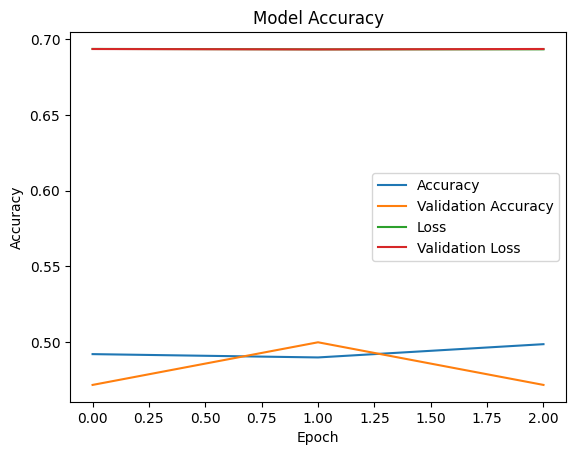

In [12]:
# Check the accuracy of the data
# Plot the results
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

# Configure the chart layout
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])

# Plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
dog


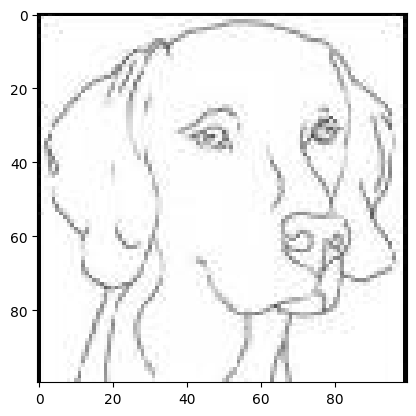

In [22]:
from keras.preprocessing import image
from keras.models import load_model

img = image.load_img("../data/raw/test/200.jpg", target_size = (100, 100), color_mode='grayscale')
img = np.asarray(img)
plt.imshow(img, cmap='gray')
img = np.expand_dims(img, axis = 0)
saved_model = load_model("../models/vgg16_best_model.keras")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print("dog")